 Φορτώθηκαν 28 τριάδες από το 'triads_at_least_2_of_top3.xlsx'

 Κορυφαίες 10 τριάδες (βάσει Median Accuracy):
                                                Trio  Median_Accuracy  \
0  (Family_History, Iodine_Deficiency, Radiation_...            0.580   
1       (Family_History, Iodine_Deficiency, Obesity)            0.570   
2     (Diabetes, Family_History, Radiation_Exposure)            0.560   
3       (Family_History, Iodine_Deficiency, Smoking)            0.560   
4       (Family_History, Gender, Radiation_Exposure)            0.560   
5      (Family_History, Radiation_Exposure, Smoking)            0.560   
6      (Diabetes, Family_History, Iodine_Deficiency)            0.555   
7   (Iodine_Deficiency, Obesity, Radiation_Exposure)            0.550   
8      (Family_History, Obesity, Radiation_Exposure)            0.550   
9        (Family_History, Gender, Iodine_Deficiency)            0.540   

   Median_AUC  
0    0.596154  
1    0.568510  
2    0.572115  
3    0.568510  
4    

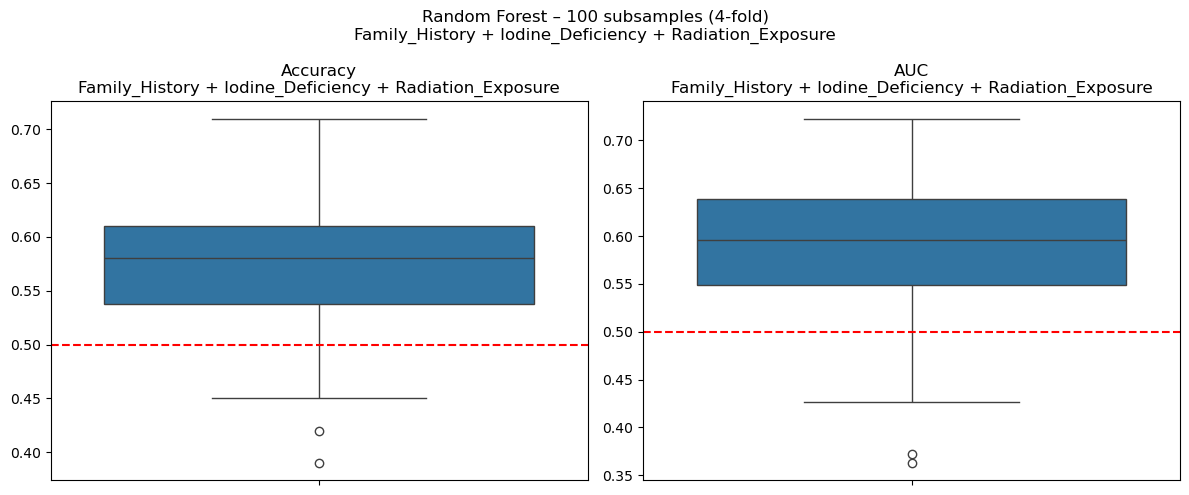

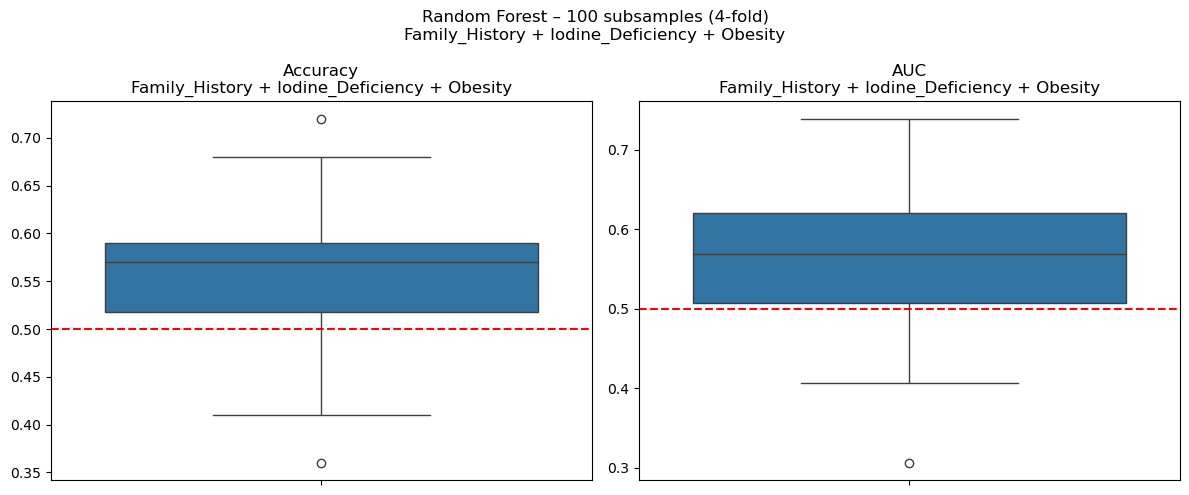

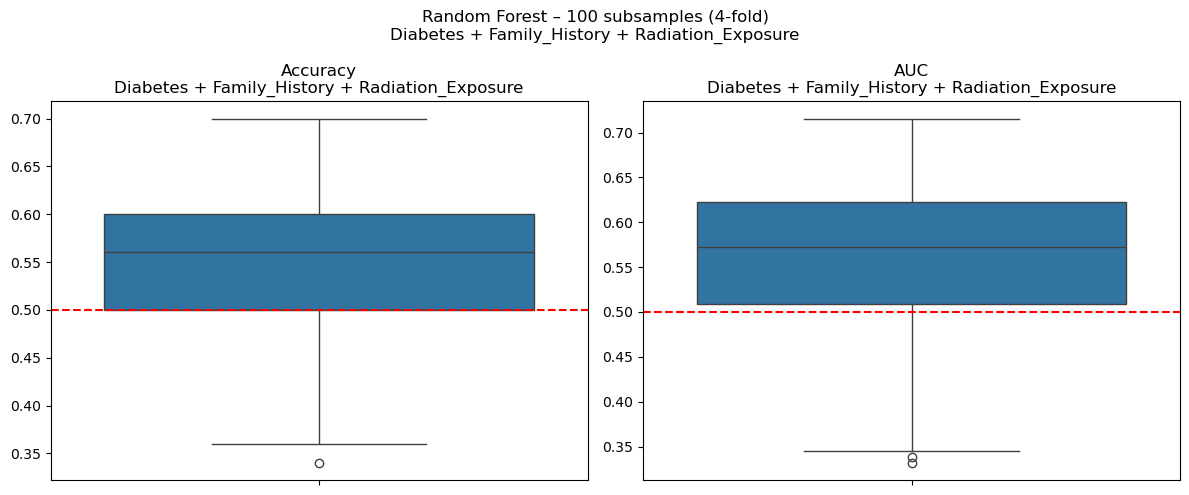

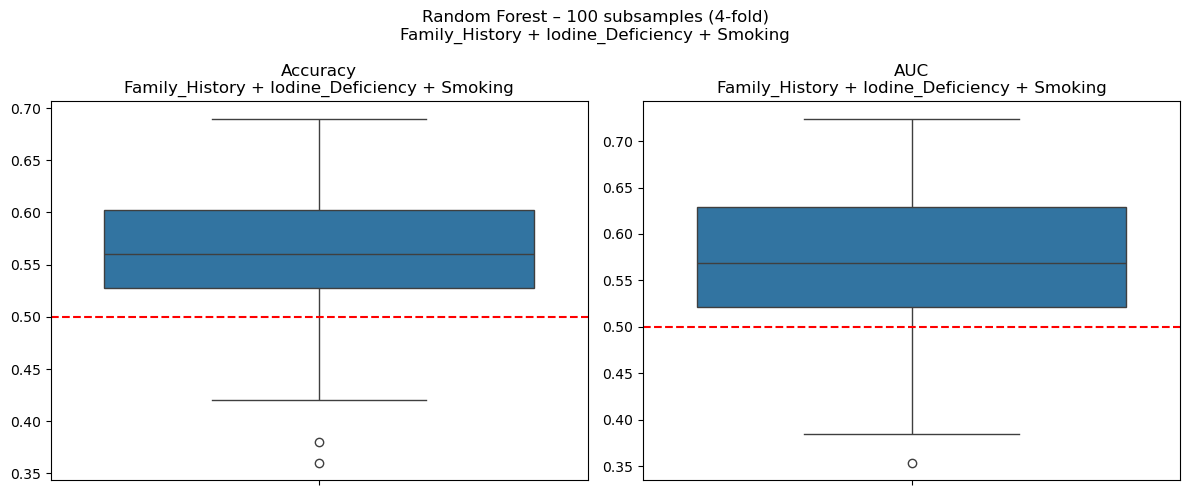

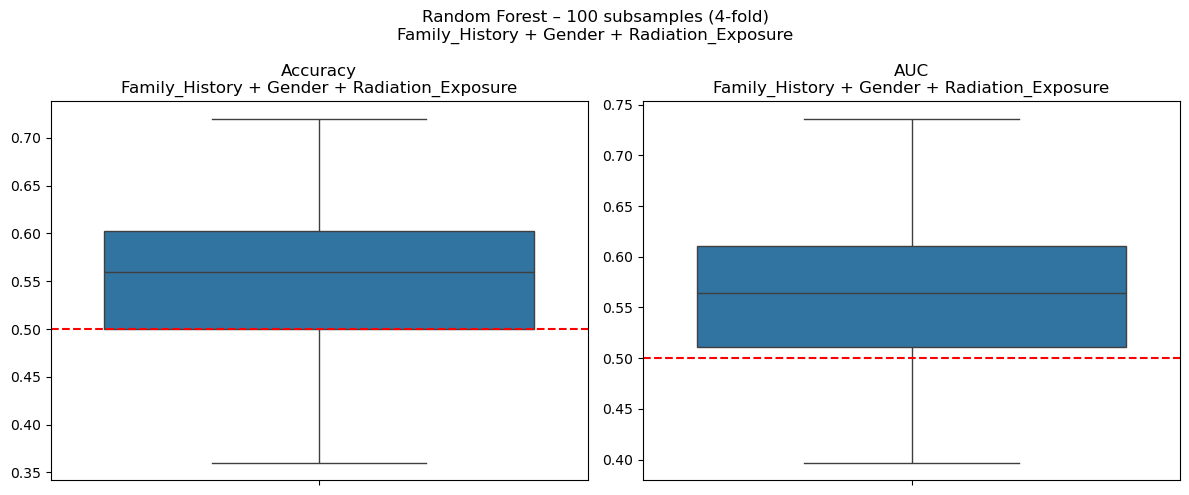

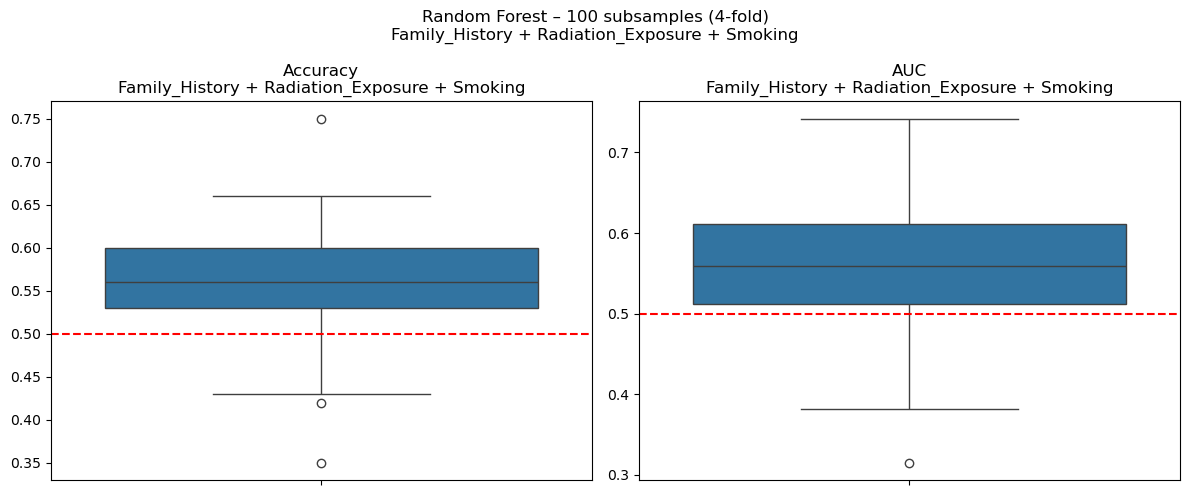

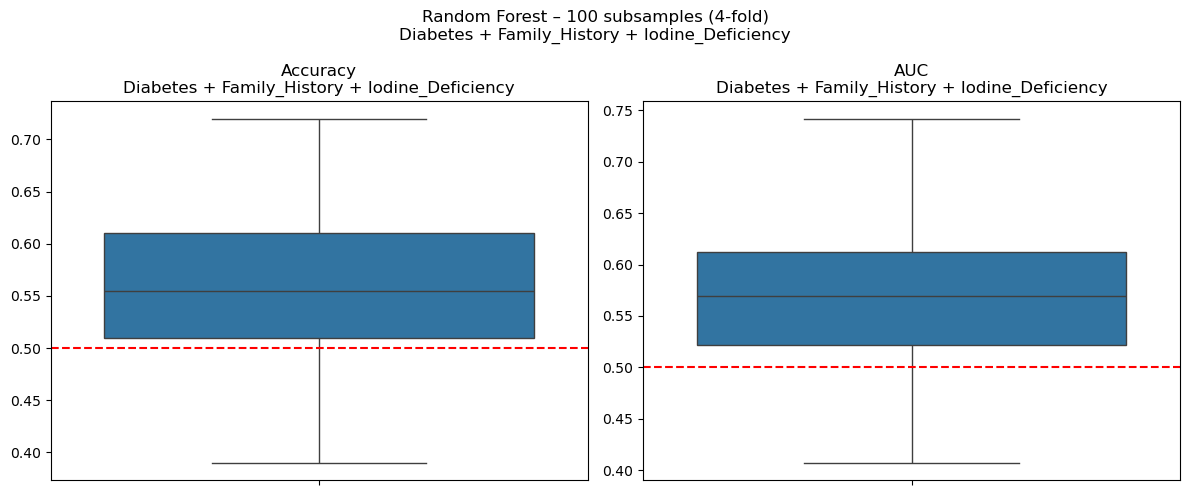

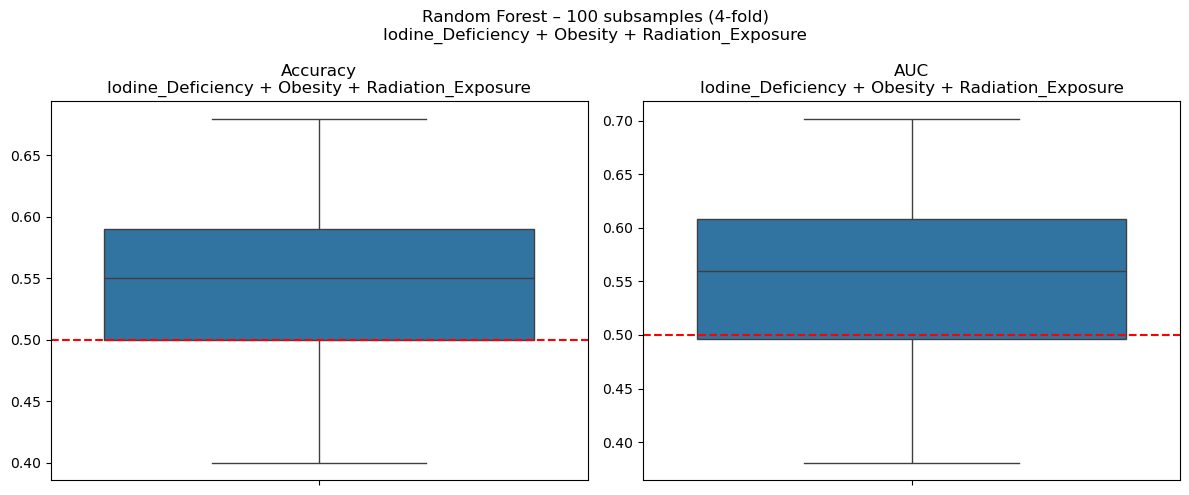

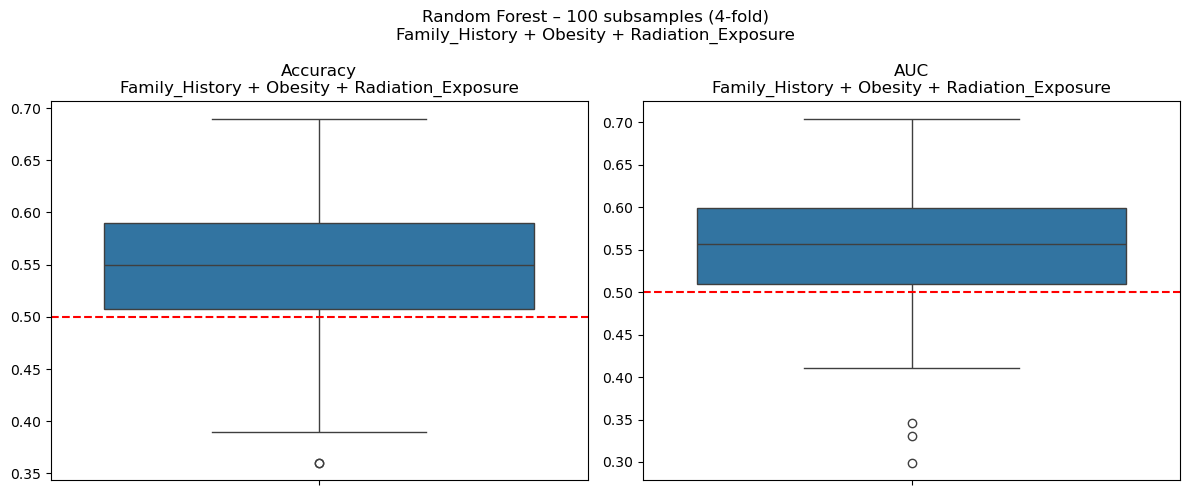

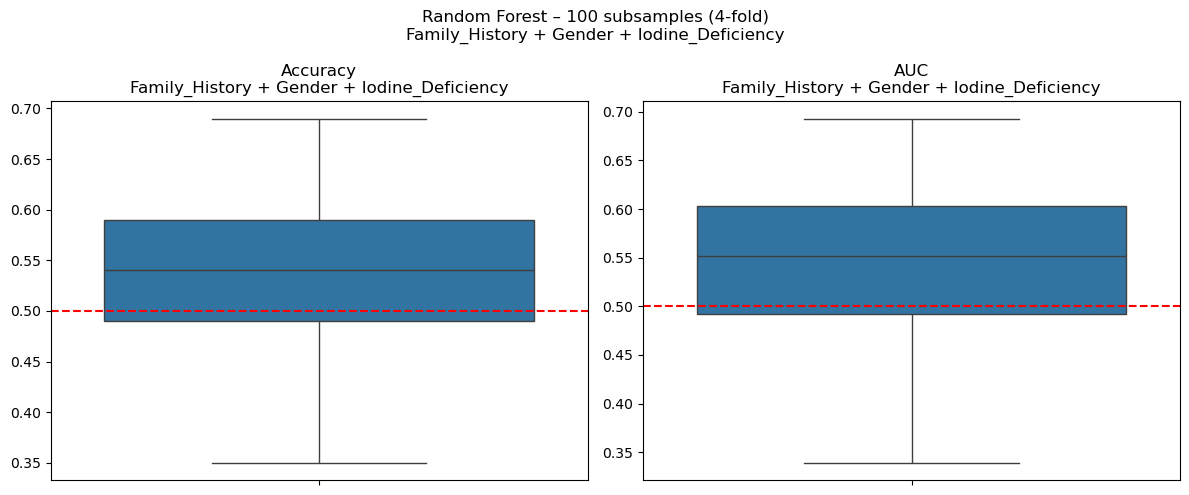

In [1]:
# Χρήση Random Forest για τους πιο σημαντικούς δείκτες που ανέδειξε μονοπαραγωντικά ο Logistic Regression.

import pandas as pd #Εισαγωγή Pandas ως κύρια βιβλιοθήκη για διαχείριση/ανάλυση πινάκων δεδομένων (DataFrames)
import numpy as np #Εισαγωγή numpy για τους υπολογισμούς των Median Accuracy & Median AUC. 
import matplotlib.pyplot as plt #Εισαγωγή Γενικής βιβλιοθήκης γραφημάτων (figures, άξονες, αποθήκευση).
import seaborn as sns #Εισαγωγή για την εξαγωγή Boxplots.
 
from itertools import islice #Εισαγωγή της συνάρτησης islice για αποδοτική επιλογή συγκεκριμένων στηλών από ακολουθίες ή DataFrames.
from sklearn.ensemble import RandomForestClassifier #Εισαγωγή του αλγορίθμου RF, γραμμικού ταξινομητή κατάλληλου για δυαδικά προβλήματα πρόβλεψης.
from sklearn.model_selection import StratifiedKFold #Εισαγωγή της μεθόδου Stratified K-Fold cross-validation, για διατήρηση αναλογιών κλάσεων κάθε υποσυνόλου εκπαίδευσης/ελέγχου.
from sklearn.metrics import accuracy_score, roc_auc_score #Εισαγωγή δεικτών απόδοσης[το ποσοστό ορθής ταξινόμησης(Accuracy) και η περιοχή κάτω από την καμπύλη ROC(ROC–AUC)].
 
# ==============================
# ΡΥΘΜΙΣΕΙΣ
# ==============================
DATASET_PATH = "Dataset_Cleaned.xlsx"           # Ορισμός του "καθαρού" dataset
TRIADS_PATH  = "triads_at_least_2_of_top3.xlsx"  #Ορισμός του αρχείου με τις τριάδες δεικτών που ανεδειξε πιο σημαντικές ο Logistic Regression
TARGET_COL   = "Diagnosis"                      # Ορισμός της μεταβλητής- στόχου
DROP_COLS    = ["Thyroid_Cancer_Risk"]          # Αφαίρεση της στήλης Thyroid_Cancer_Risk 
N_PER_CLASS  = 50                               # Ορισμός μεγέθους subsample ανά κλάση (0 & 1).
N_REPEATS    = 100                              # Ορισμός επαναλήψεων subsampling
N_SPLITS     = 4                                # Αριθμός StratifiedKFold splits
TOP_K        = 10                               # Πλήθος κορυφαίων τριάδων που θα παρουσιαστούν.
SAVE_PLOTS   = False                            # Αν αληθές, αποθήκευση παραγόμενων γραφημάτων ως PNG για κάθε τριάδα
 
# ==============================
# 1) ΦΟΡΤΩΣΗ ΔΕΔΟΜΕΝΩΝ
# ==============================
df = pd.read_excel(DATASET_PATH) # Ανάγνωση του καθαρισμένου πίνακα δεδομένων.

# Προαιρετική αφαίρεση πεδίων που μπορεί να εισάγουν μεροληψία στη μοντελοποίηση.
for c in DROP_COLS:
    if c in df.columns:
        df = df.drop(columns=[c])
        
# Έλεγχος ύπαρξης μεταβλητής-στόχου - Προληπτικός έλεγχος ακεραιότητας σχεδίου ανάλυσης.
if TARGET_COL not in df.columns:
    raise ValueError(f"Δεν βρέθηκε η στήλη στόχου '{TARGET_COL}' στο dataset.")

# Μετατροπή στόχου σε αριθμητικό τύπο, απαλοιφή NaN, και διατήρηση αμιγώς δυαδικών τιμών (0/1).
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
df = df.dropna(subset=[TARGET_COL])
df = df[df[TARGET_COL].isin([0, 1])]
 
# ==============================
# 2) ΦΟΡΤΩΣΗ ΤΡΙΑΔΩΝ
# ==============================
triads_df = pd.read_excel(TRIADS_PATH) #Φόρτωση υποψηφίων τριάδων από εξωτερικό αρχείο.
                          
# Χρήση των τριών πρώτων στηλών του αρχείου ως ονόματα δεικτών (ανεξαρτήτως επικεφαλίδων στηλών).
if triads_df.shape[1] < 3:
    raise ValueError("Το αρχείο με τις τριάδες πρέπει να έχει τουλάχιστον 3 στήλες.")
 
triads = []
first_three_cols = list(islice(triads_df.columns, 3))  #Αποδοτική επιλογή των 3 πρώτων headers.
for _, row in triads_df.iterrows():
    trio = tuple(str(row[c]).strip() for c in first_three_cols) # Κανονικοποίηση σε strings.
     # Παράλειψη ατελών γραμμών (κενές/NaN τιμές) για αποφυγή σφαλμάτων downstream.
    if any(v.lower() in ["nan", "none", ""] for v in trio):
        continue
    triads.append(trio)
    
 # Αφαίρεση διπλοτύπων τριάδων με διατήρηση σειράς εμφάνισης.
triads = list(dict.fromkeys(triads))

print(f" Φορτώθηκαν {len(triads)} τριάδες από το '{TRIADS_PATH}'")
 
# ==============================
# 3) ΒΟΗΘΗΤΙΚΑ
# ==============================
rng = np.random.default_rng(seed=42) # Γεννήτρια τυχαιότητας για αναπαραγωγιμότητα subsampling/KFold.

def evaluate_triad(df, markers, n_per_class=50, n_repeats=100, n_splits=4):
    """
    Εκτέλεση επαναληπτικού πειράματος για μία τριάδα δεικτών:
    1)Με ισσοροπημένο subsampling 
    2)& StratifiedKFold επιστρέφοντας τις λίστες με υπολογισμένα Μean Accuracy & mean AUC ανά επανάληψη.
    """
    #Έλεγχος ύπαρξης όλων των δεικτών στο dataset (αμυντικός προγραμματισμός).
    if not all(m in df.columns for m in markers):
        return None, None

    # Numeric Coercion των επιλεγμένων δεικτών της τριάδας & του πεδίου στόχου,
    # σε αριθμητικό τύπο και απαλοιφή ελλιπών τιμών (listwise deletion).
    tmp = df[list(markers) + [TARGET_COL]].copy()
    for m in markers:
        tmp[m] = pd.to_numeric(tmp[m], errors="coerce")
    tmp = tmp.dropna()

    # Διάσπαση σε δύο ομάδες στόχου για ισόποσο δειγματοληπτικό έλεγχο.
    g0 = tmp[tmp[TARGET_COL] == 0]
    g1 = tmp[tmp[TARGET_COL] == 1]

    # Ελάχιστη απαίτηση μεγέθους για εφικτό subsampling.
    if len(g0) < n_per_class or len(g1) < n_per_class:
        return None, None
 
    acc_list, auc_list = [], [] #Δημιουργία συγκεντρωτικών λιστών επιδόσεων ανά επανάληψη.
 
    for _ in range(n_repeats):
        #Ισοστάθμιση κλάσεων: τυχαία δειγματοληψία ίσου πλήθους από 0 και 1 (μείωση class imbalance bias).
        s0 = g0.sample(n=n_per_class, random_state=rng.integers(0, 10_000))
        s1 = g1.sample(n=n_per_class, random_state=rng.integers(0, 10_000))
        sample = pd.concat([s0, s1], ignore_index=True)
 
        X = sample[list(markers)].values #Πίνακας χαρακτηριστικών της συγκεκριμένης τριάδας.
        y = sample[TARGET_COL].values #Δυαδικός στόχος.

        # Διαστρωματωμένη K-fold για διατήρηση αναλογιών κλάσεων σε κάθε fold, περιορίζοντας τη διακύμανση.
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True,
                              random_state=rng.integers(0, 10_000))
        fold_acc, fold_auc = [], [] # Λίστες για αποθήκευση μετρικών ανά fold.
 
        for train_idx, test_idx in skf.split(X, y):
            model = RandomForestClassifier( 
                n_estimators=100,   # Το μοντέλο Random Forest αποτελείται από 100 δέντρα απόφασης.
                random_state=42    # Σταθερό seed για επαναληψιμότητα αποτελεσμάτων.
            )
            model.fit(X[train_idx], y[train_idx]) # Εκπαίδευση του Random Forest με το training set κάθε fold.
 
            preds = model.predict(X[test_idx]) #Δυαδικές προβλέψεις για Accuracy.
            probs = model.predict_proba(X[test_idx])[:, 1] #Πιθανότητες κλάσης 1 για ROC–AUC.
 
            fold_acc.append(accuracy_score(y[test_idx], preds)) #Ποιότητα σωστών ταξινομήσεων.
            fold_auc.append(roc_auc_score(y[test_idx], probs)) #Διαχωριστική ικανότητα ανεξάρτητη κατωφλίου.
 
        #Μέσοι όροι ανά fold (per repeat) για μείωση της εξάρτησης από ένα τυχαίο split.
        acc_list.append(float(np.mean(fold_acc)))
        auc_list.append(float(np.mean(fold_auc)))
 
    return acc_list, auc_list #Επιστροφή των κατανομών επιδόσεων για μεταγενέστερη σύγκριση/οπτικοποίηση.
 
# ==============================
# 4) ΚΥΡΙΟΣ ΒΡΟΧΟΣ ΑΠΟΤΙΜΗΣΗΣ
# ==============================
all_results = []       #Συνοπτικός πίνακας ανά τριάδα με median δεικτών επίδοσης.
box_data = {}          # Αποθήκευση αναλυτικών λιστών acc/auc για κάθε τριάδα 

for trio in triads:
    # Παράλειψη τριάδων που δεν υπάρχουν στο dataset — αποφυγή ψευδών σφαλμάτων.
    missing = [m for m in trio if m not in df.columns]
    if missing:
        print(f" Αγνόηση τριάδας (λείπουν στήλες): {trio} -> {missing}")
        continue
 
   # Εκτέλεση αξιολόγησης για την τριάδα με ορισμένες παραμέτρους δειγματοληψίας/επικύρωσης.
    acc_list, auc_list = evaluate_triad(df, trio,
                                        n_per_class=N_PER_CLASS,
                                        n_repeats=N_REPEATS,
                                        n_splits=N_SPLITS)
    if acc_list is None:
        print(f" Μικρό δείγμα, παράλειψη τριάδας: {trio}")
        continue

    #Χρήση median (ανθεκτικότητας σε ακραίες τιμές) ως σύντομης περίληψης επίδοσης.
    med_acc = float(np.median(acc_list))
    med_auc = float(np.median(auc_list))

    all_results.append({
        "Trio": trio,
        "Median_Accuracy": med_acc,
        "Median_AUC": med_auc
    })

    #Φύλαξη των αναλυτικών κατανομών σε λεξικό για μεταγενέστερη οπτικοποίηση/αναφορά με boxplots.
    box_data[trio] = {"acc": acc_list, "auc": auc_list}

#Σε περίπτωση καμίας έγκυρης τριάδας, διακοπή με σαφές μήνυμα σφάλματος.
 
if not all_results:
    raise RuntimeError("Δεν προέκυψαν έγκυρα αποτελέσματα για καμία τριάδα.")
    
#Ταξινόμηση αποτελεσμάτων κατά προτεραιότητα Median Accuracy και δευτερευόντως AUC.
results_df = pd.DataFrame(all_results).sort_values(
    by=["Median_Accuracy", "Median_AUC"], ascending=False
).reset_index(drop=True)
 
print("\n Κορυφαίες 10 τριάδες (βάσει Median Accuracy):")
print(results_df.head(TOP_K)) #Γρήγορη αναφορά των καλύτερων συνδυασμών δεικτών.
 
# ==============================
# 5) BOXPlots ΓΙΑ ΤΙΣ TOP-10 ΤΡΙΑΔΕΣ
# ==============================
top10_trios = list(results_df.head(TOP_K)["Trio"]) #Επιλογή των κορυφαίων τριάδων προς απεικόνιση.
 
for trio in top10_trios:
    acc_list = box_data[trio]["acc"]  #Κατανομή Accuracy (per repeat).
    auc_list = box_data[trio]["auc"] #Κατανομή AUC (per repeat).
    trio_label = " + ".join(trio) #Ετικέτα γραφήματος με τα ονόματα δεικτών.
 
    plt.figure(figsize=(12, 5)) #Ευανάγνωστη σχεδίαση με αναλογία 12×5.
 
    plt.subplot(1, 2, 1) #Αριστερό υπογράφημα: Αccuracy
    
    sns.boxplot(y=acc_list) #Boxplot της κατανομής ACC στις 100 επαναλήψεις.
    plt.title(f"Accuracy\n{trio_label}") #Τίτλος με την τριάδα που αξιολογείται.
    plt.axhline(0.5, linestyle='--', color='red')  #Οριζόντια γραμμή αναφοράς (baseline) στο 0.5.
 
    plt.subplot(1, 2, 2)  #Δεξί υπο-γράφημα: AUC (επιλέγουμε μόνο αυτό εδώ).
    
    sns.boxplot(y=auc_list)  #Boxplot της κατανομής AUC στις 100 επαναλήψεις.
    plt.title(f"AUC\n{trio_label}") #Τίτλος με την τριάδα που αξιολογείται.
    plt.axhline(0.5, linestyle='--', color='red') #Γραμμή τυχαίας απόδοσης (no-skill baseline).
 
    plt.suptitle(f"Random Forest – 100 subsamples (4-fold)\n{trio_label}") #Σύνοψη μεθοδολογίας.
    plt.tight_layout()  #Βελτιστοποίηση κενών για καθαρή εμφάνιση.
    plt.show() #Απόδοση του σχήματος στην έξοδο.
 
    if SAVE_PLOTS: # Προαιρετική αποθήκευση για τεκμηρίωση/παράρτημα.
        safe_name = "_".join([s.replace(" ", "_").replace("/", "_") for s in trio])
        plt.savefig(f"rf_boxplot_{safe_name}.png", dpi=150, bbox_inches="tight")
        plt.close()